# Pneumonia Detection in X-rays

Pneumonia is a serious respiratory infection that inflames the air sacs in one or both lungs, which can be caused by bacteria, viruses, or fungi. Detecting pneumonia accurately and promptly is crucial for effective treatment and patient recovery. Chest X-rays are a common diagnostic tool used by radiologists to identify signs of pneumonia, such as lung opacities and consolidation.

Recent advancements in machine learning and computer vision have enabled the development of automated systems to assist in pneumonia detection from X-ray images. These systems use deep learning models, particularly Convolutional Neural Networks (CNNs), to analyze chest X-rays and identify patterns indicative of pneumonia with high accuracy.

The automated detection of pneumonia in X-rays offers several benefits:

- **Improved Accuracy**: Machine learning models can be trained on large datasets of labeled X-rays, enabling them to detect subtle signs of pneumonia that might be missed by human observers.
- **Increased Efficiency**: Automated systems can process X-ray images quickly, providing faster diagnostic support, especially in high-demand settings.
- **Accessibility**: Such systems can be deployed in areas with limited access to specialized radiologists, improving healthcare delivery in underserved regions.

In this project, we will explore the application of deep learning techniques to develop an effective model for pneumonia detection in chest X-rays. By leveraging publicly available datasets, we will train and evaluate different models to assess their performance in identifying pneumonia, aiming to contribute to the ongoing efforts in enhancing medical diagnostics through AI.


## Data Overview

In this project, we will be using a dataset of chest X-ray images to detect pneumonia. The dataset contains two primary classes:

- **Normal:** X-ray images that show no signs of pneumonia.
- **Pneumonia:** X-ray images that indicate the presence of pneumonia, which may be caused by bacterial or viral infections.

### Dataset Source

The dataset used in this project is publicly available and has been widely used for research in medical image analysis. It consists of thousands of chest X-ray images, which have been labeled by expert radiologists.

### Data Structure

The dataset is organized into two main directories, each containing subdirectories for training, validation, and testing:

- `train/`: Contains the training images, split into `NORMAL` and `PNEUMONIA` classes.
- `val/`: Contains the validation images, used for model tuning.
- `test/`: Contains the test images, used for evaluating the model's performance.

Each image is stored in JPEG format, and the typical resolution of the images is 1024x1024 pixels.

### Data Distribution

The dataset has a class imbalance, with more pneumonia cases than normal cases. This imbalance will be taken into account during model training, and techniques such as data augmentation or class weighting may be applied to address it.

### Preprocessing Steps

Before feeding the data into the model, the following preprocessing steps will be applied:

- **Resizing:** All images will be resized to a uniform resolution suitable for the input layer of the neural network.
- **Normalization:** Pixel values will be normalized to a range of [0, 1] to improve model convergence.

This overview provides a detailed understanding of the dataset, its structure, and the preprocessing steps that will be performed before model training.


In [1]:
import os
import time
import cv2
import random
import numpy as np
from scipy.ndimage import zoom, shift, rotate
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, GlobalAveragePooling2D, BatchNormalization, MaxPool2D
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from livelossplot import PlotLossesKeras
import warnings
warnings.filterwarnings('ignore')
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Define custom progress bar format with ANSI color codes
bar_format = "\033[0;30mLoading Images: \033[0;32m{bar:20}\033[0m {n_fmt}/{total_fmt} {percentage:3.0f}%"

In [2]:
# Parameters
img_size = 224
batch_size = 32
epochs = 50
lr = 5e-5
loss = 'binary_crossentropy'

In [3]:
# Define data path
train_n_path = os.path.join(os.getcwd(), "datasets", "chest_xray", "train", "NORMAL")
train_p_path = os.path.join(os.getcwd(), "datasets", "chest_xray", "train", "PNEUMONIA")
val_n_path = os.path.join(os.getcwd(), "datasets", "chest_xray", "val", "NORMAL")
val_p_path = os.path.join(os.getcwd(), "datasets", "chest_xray", "val", "PNEUMONIA")
test_n_path = os.path.join(os.getcwd(), "datasets", "chest_xray", "test", "NORMAL")
test_p_path = os.path.join(os.getcwd(), "datasets", "chest_xray", "test", "PNEUMONIA")

In [4]:
# Get the file names
train_n_names = os.listdir(train_n_path)
train_p_names = os.listdir(train_p_path)
val_n_names = os.listdir(val_n_path)
val_p_names = os.listdir(val_p_path)
test_n_names = os.listdir(test_n_path)
test_p_names = os.listdir(test_p_path)

In [5]:
# Data for plotting
categories = ['Normal', 'Pneumonia']
train_counts = [len(train_n_names), len(train_p_names)]
val_counts = [len(val_n_names), len(val_p_names)]
test_counts = [len(test_n_names), len(test_p_names)]

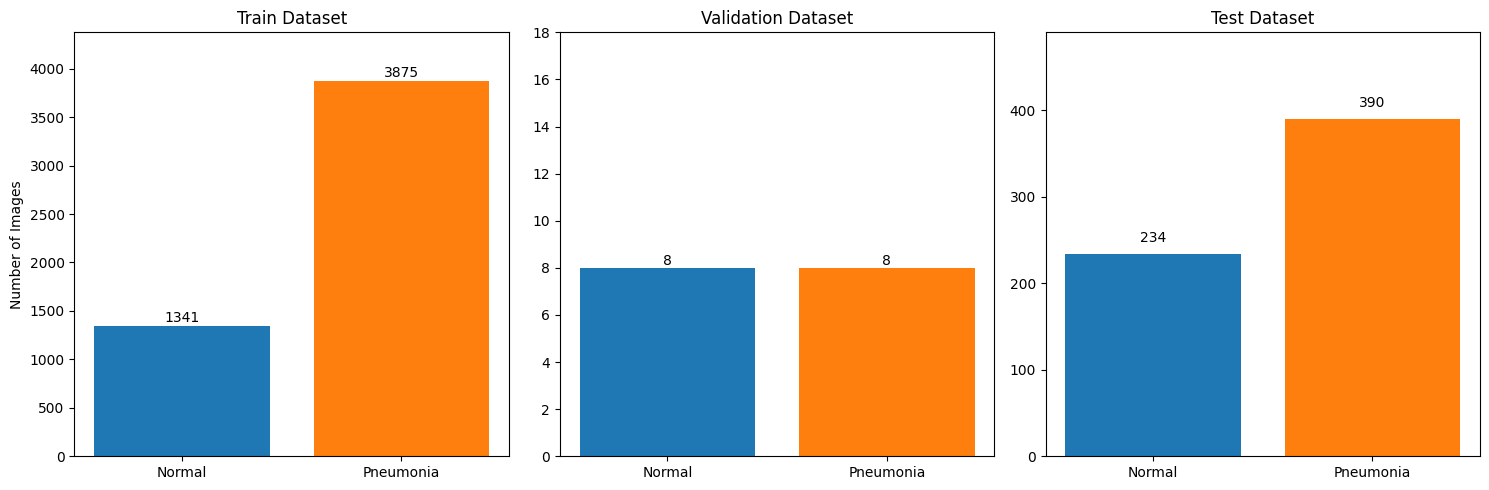

In [6]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Function to add text on top of bars
def add_labels(ax, counts):
    # Get the y-axis limit
    y_lim = ax.get_ylim()[1]
    for i, count in enumerate(counts):
        # Add a label above the bar but below the maximum y-axis limit
        label_y = min(count + 10, y_lim - 10)  # Ensure label stays within plot
        ax.text(i, label_y, str(count), ha='center', va='bottom')

# Train dataset bar plot
axs[0].bar(categories, train_counts, color=['#1f77b4', '#ff7f0e'])
axs[0].set_title('Train Dataset')
axs[0].set_ylabel('Number of Images')
axs[0].set_ylim(0, max(train_counts) + 500)  # Adjust y-axis limit
add_labels(axs[0], train_counts)  # Add labels

# Validation dataset bar plot
axs[1].bar(categories, val_counts, color=['#1f77b4', '#ff7f0e'])
axs[1].set_title('Validation Dataset')
axs[1].set_ylim(0, max(val_counts) + 10)  # Adjust y-axis limit
add_labels(axs[1], val_counts)  # Add labels

# Test dataset bar plot
axs[2].bar(categories, test_counts, color=['#1f77b4', '#ff7f0e'])
axs[2].set_title('Test Dataset')
axs[2].set_ylim(0, max(test_counts) + 100)  # Adjust y-axis limit
add_labels(axs[2], test_counts)  # Add labels

# Adjust layout and show plot
plt.tight_layout()
plt.show()

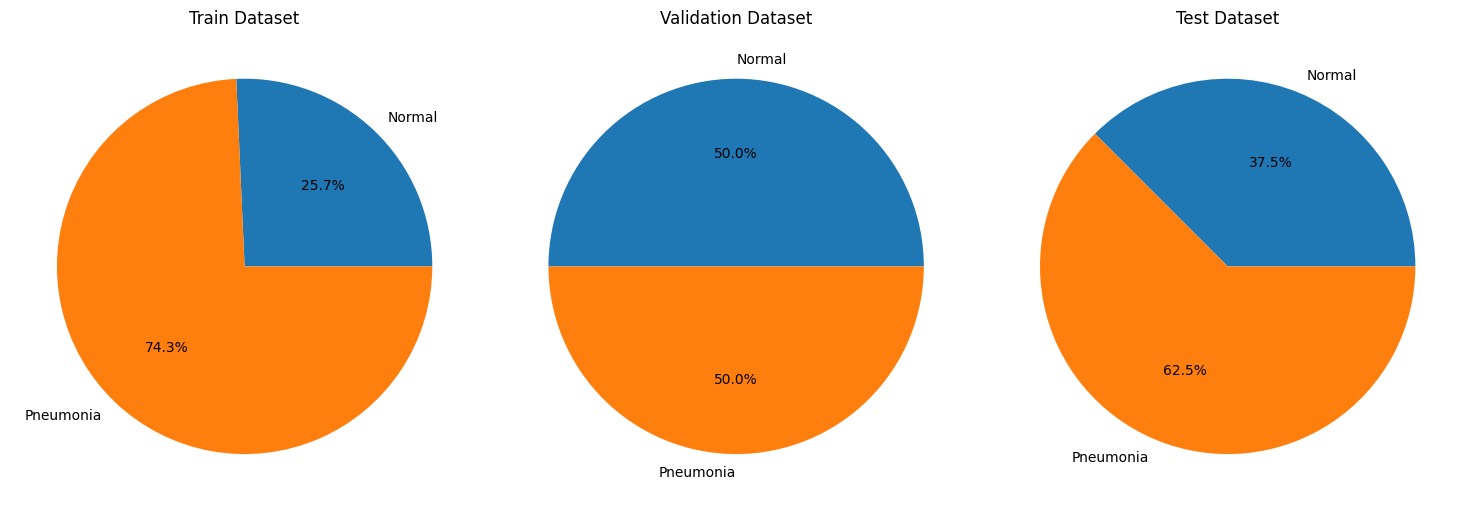

In [7]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Training Pie Chart
axs[0].pie(train_counts, labels=categories, autopct='%1.1f%%', colors=['#1f77b4','#ff7f0e'])
axs[0].set_title('Train Dataset')

# Validation Pie Chart
axs[1].pie(val_counts, labels=categories, autopct='%1.1f%%', colors=['#1f77b4','#ff7f0e'])
axs[1].set_title('Validation Dataset')

# Test Pie Chart
axs[2].pie(test_counts, labels=categories, autopct='%1.1f%%', colors=['#1f77b4','#ff7f0e'])
axs[2].set_title('Test Dataset')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

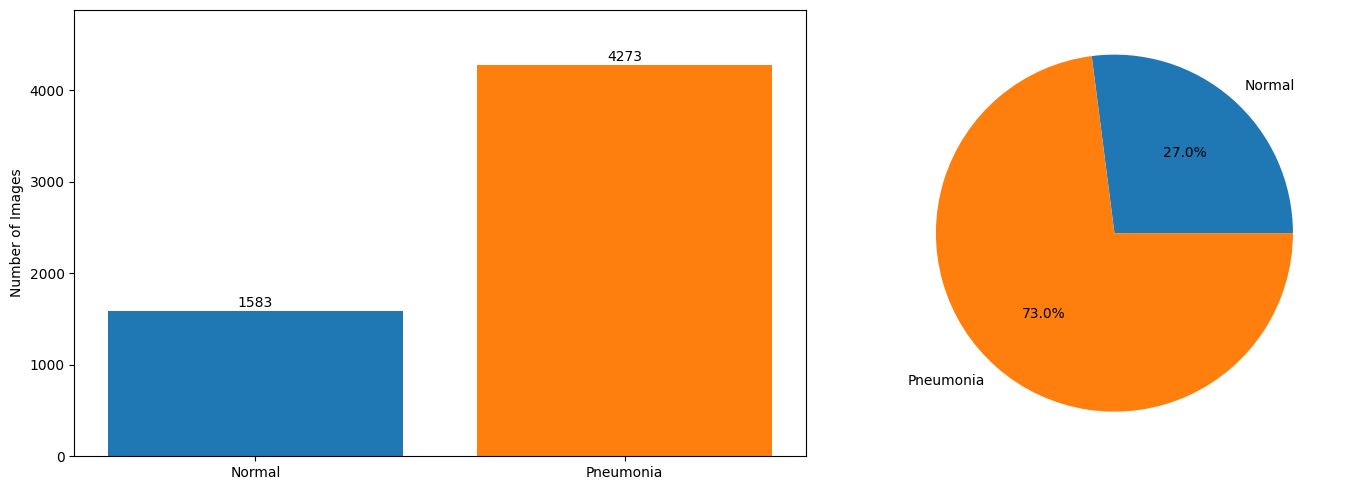

In [8]:
total_counts = [train_counts[0]+val_counts[0]+test_counts[0], train_counts[1]+val_counts[1]+test_counts[1]]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Total dataset bar plot
axs[0].bar(categories, total_counts, color=['#1f77b4', '#ff7f0e'])
axs[0].set_ylabel('Number of Images')
axs[0].set_ylim(0, max(train_counts) + 1000)  # Adjust y-axis limit
add_labels(axs[0], total_counts)  # Add labels

# Total dataset Pie Chart
axs[1].pie(total_counts, labels=categories, autopct='%1.1f%%', colors=['#1f77b4','#ff7f0e'])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Observations on Class Imbalance

The figures presented above clearly demonstrate a significant class imbalance in the dataset, with a much higher number of pneumonia cases compared to normal cases. This imbalance can negatively impact model performance, as the model may become biased towards the more frequent class, leading to poor generalization and lower accuracy for the underrepresented class.

### Addressing Imbalance by Shrinking the Dataset

One potential approach to address this imbalance is to shrink the dataset by reducing the number of images in the larger class (pneumonia) to match the number of images in the smaller class (normal). This can help to create a more balanced dataset, which is critical for training a model that performs well across both classes.

### Feasibility of Using a Smaller Dataset

Given that the dataset consists of only two classes (normal and pneumonia), a balanced dataset with around 1000 images per class should be sufficient for training. Research and practical examples, such as the ImageNet dataset, support this. ImageNet, for instance, contains over a million images across 1,000 classes. Even with fewer images per class, models can effectively learn to distinguish between classes, as demonstrated by the success of deep learning models trained on ImageNet. With proper data representation and augmentation, a balanced dataset with 1000 images per class can provide the necessary information for effective model training. In this project, data augmentation will not be explored.


In [9]:
def read_images(path, names):
    img_data = np.zeros((len(names), img_size, img_size, 3), dtype=np.float32)

    # Define custom progress bar format with ANSI color codes
    #bar_format = "\033[0;30mLoading Images: \033[0;32m{bar:20}\033[0m {n_fmt}/{total_fmt} {percentage:3.0f}%"
    
    for i, name in tqdm(enumerate(names), total=len(names), desc="Loading Images", bar_format=bar_format):
    #for i in range(len(names)):
        img = cv2.imread(os.path.join(path, name))[..., ::-1]
        img_data[i, ...] = cv2.resize(img, (img_size, img_size))

    return img_data


train_n = read_images(train_n_path, train_n_names)
train_p = read_images(train_p_path, train_p_names)
val_n = read_images(val_n_path, val_n_names)
val_p = read_images(val_p_path, val_p_names)
test_n = read_images(test_n_path, test_n_names)
test_p = read_images(test_p_path, test_p_names)

Loading Images: ████████████████████ 1341/1341 100%
Loading Images: ████████████████████ 3875/3875 100%
Loading Images: ████████████████████ 8/8 100%
Loading Images: ████████████████████ 8/8 100%
Loading Images: ████████████████████ 234/234 100%
Loading Images: ████████████████████ 390/390 100%


In [10]:
dataset_n = np.concatenate((train_n, val_n, test_n), axis=0)
dataset_p = np.concatenate((train_p, val_p, test_p), axis=0)

In [11]:
min_val = min(len(dataset_n), len(dataset_p))

dataset_n = dataset_n[:min_val, ...]
dataset_p = dataset_p[:min_val, ...]

In [12]:
index = int(min_val/10)

train_n = dataset_n[2*index:]
train_p = dataset_p[2*index:]
val_n = dataset_n[:index]
val_p = dataset_p[:index]
test_n = dataset_n[index:2*index]
test_p = dataset_p[index:2*index]

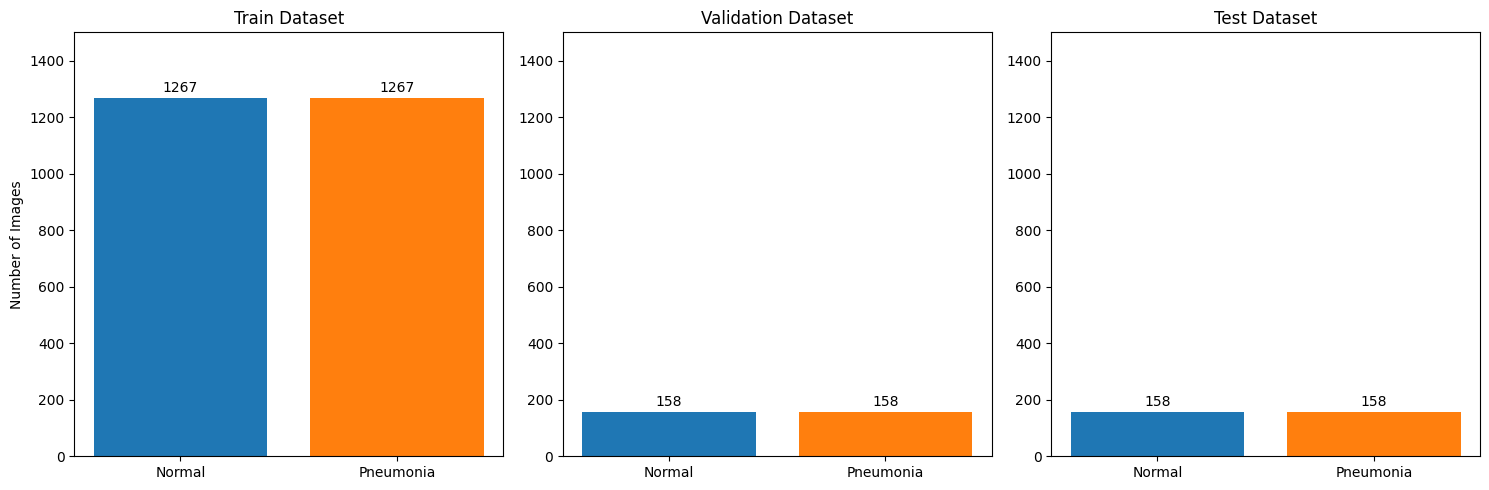

In [13]:
train_counts = [len(train_n), len(train_p)]
val_counts = [len(val_n), len(val_p)]
test_counts = [len(test_n), len(test_p)]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Function to add text on top of bars
def add_labels(ax, counts):
    # Get the y-axis limit
    y_lim = ax.get_ylim()[1]
    for i, count in enumerate(counts):
        # Add a label above the bar but below the maximum y-axis limit
        label_y = min(count + 10, y_lim - 10)  # Ensure label stays within plot
        ax.text(i, label_y, str(count), ha='center', va='bottom')

# Train dataset bar plot
axs[0].bar(categories, train_counts, color=['#1f77b4', '#ff7f0e'])
axs[0].set_title('Train Dataset')
axs[0].set_ylabel('Number of Images')
axs[0].set_ylim(0, 1500)  # Adjust y-axis limit
add_labels(axs[0], train_counts)  # Add labels

# Validation dataset bar plot
axs[1].bar(categories, val_counts, color=['#1f77b4', '#ff7f0e'])
axs[1].set_title('Validation Dataset')
axs[1].set_ylim(0, 1500)  # Adjust y-axis limit
add_labels(axs[1], val_counts)  # Add labels

# Test dataset bar plot
axs[2].bar(categories, test_counts, color=['#1f77b4', '#ff7f0e'])
axs[2].set_title('Test Dataset')
axs[2].set_ylim(0, 1500)  # Adjust y-axis limit
add_labels(axs[2], test_counts)  # Add labels

# Adjust layout and show plot
plt.tight_layout()
plt.show()

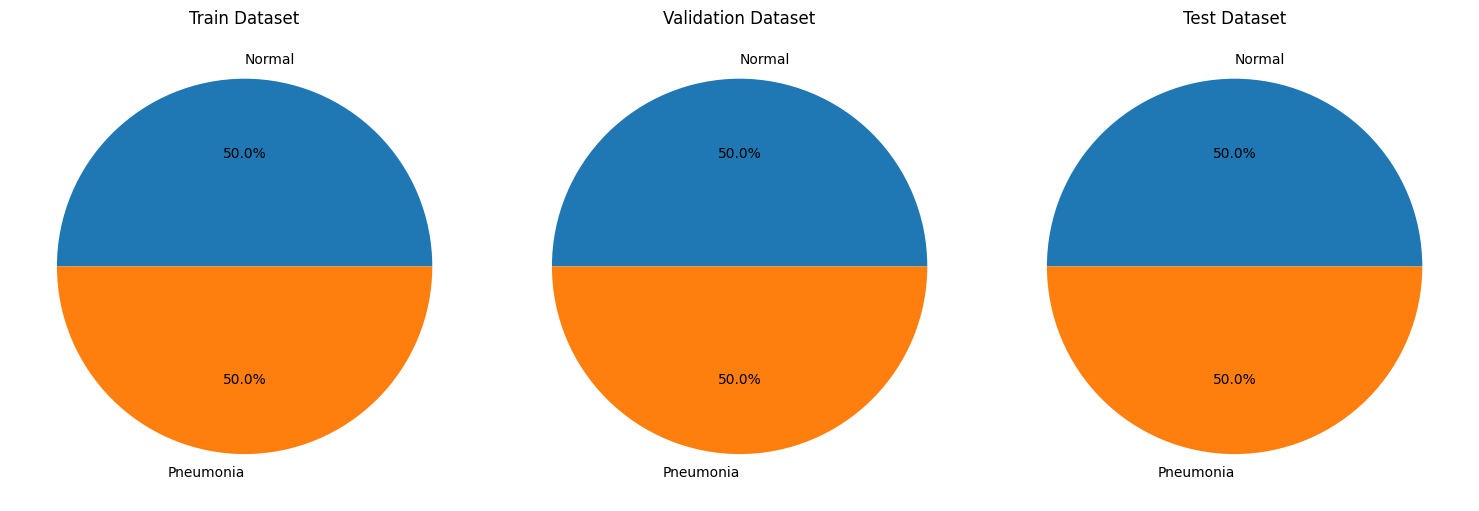

In [14]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Training Pie Chart
axs[0].pie(train_counts, labels=categories, autopct='%1.1f%%', colors=['#1f77b4','#ff7f0e'])
axs[0].set_title('Train Dataset')

# Validation Pie Chart
axs[1].pie(val_counts, labels=categories, autopct='%1.1f%%', colors=['#1f77b4','#ff7f0e'])
axs[1].set_title('Validation Dataset')

# Test Pie Chart
axs[2].pie(test_counts, labels=categories, autopct='%1.1f%%', colors=['#1f77b4','#ff7f0e'])
axs[2].set_title('Test Dataset')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

## Identifying Pneumonia on Chest X-rays

Determining if an X-ray shows pneumonia involves identifying specific radiological features associated with the infection. Here are key signs and methods used to diagnose pneumonia on a chest X-ray:

### Key Features of Pneumonia on X-rays

1. **Consolidation** Areas of the lung appear opaque or white due to the accumulation of fluid or pus in the alveoli. This appears as a dense, opaque region on the X-ray.

2. **Infiltrates** Patchy or diffuse areas of increased density that are not as well-defined as consolidation. These can appear as irregular or cloud-like areas on the X-ray.

3. **Air Bronchograms** The outlines of the bronchi (airways) become visible within the area of consolidation because the surrounding lung tissue is more opaque. Air-filled bronchi appear as dark, branching structures against a white background of consolidated lung.

4. **Pleural Effusion** Fluid accumulation in the pleural space (the area between the lungs and the chest wall) can accompany pneumonia. This often appears as a blurring of the boundary between the lung and the chest wall, sometimes with a meniscus shape.

5. **Lung Opacities** Generalized cloudiness or loss of normal lung markings due to the presence of fluid, pus, or other materials. This can obscure the normal structure of the lung on the X-ray.

6. **Cavitations** In some cases of pneumonia, especially with certain pathogens, cavities or abscesses can form within the lung tissue. These appear as areas with irregular outlines and can contain air-fluid levels.



By carefully analyzing these features, medical professionals can diagnose pneumonia and determine the appropriate treatment course. Building an AI model can automate the analysis accurately. In the following figure, you can see some these features in the X-ray comparison between normal and pneumonia diagnosed images.


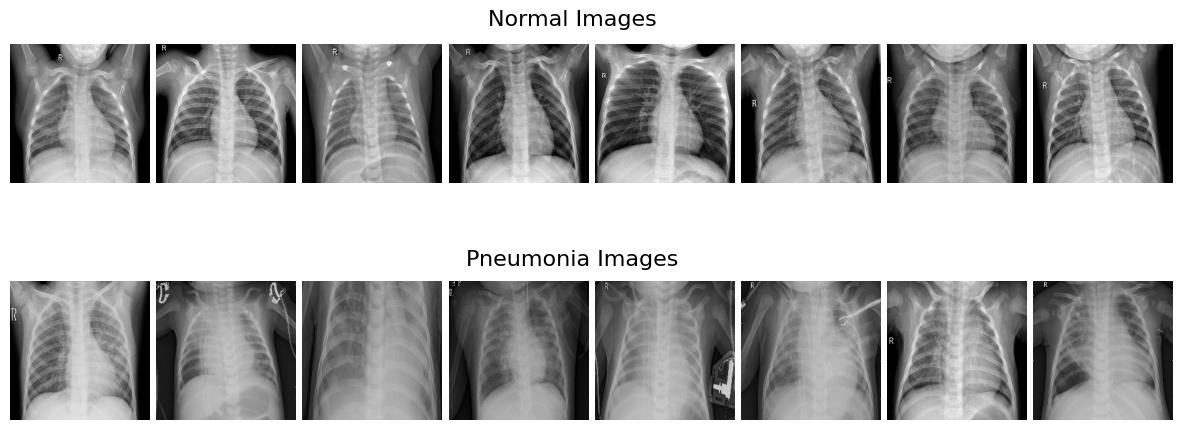

In [15]:
# Create a figure
fig, axs = plt.subplots(2, 8, figsize=(15, 6))

# Display Normal Images
for j in range(8):
    axs[0, j].imshow(np.uint8(train_n[j]))
    axs[0, j].axis("off")
    axs[0, j].set_xticklabels([])
    axs[0, j].set_yticklabels([])
    axs[0, j].set_aspect('equal')

# Display Pneumonia Images
for j in range(8):
    axs[1, j].imshow(np.uint8(train_p[j]))
    axs[1, j].axis("off")
    axs[1, j].set_xticklabels([])
    axs[1, j].set_yticklabels([])
    axs[1, j].set_aspect('equal')

# Add titles for each row
fig.text(0.5, 0.85, 'Normal Images', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.45, 'Pneumonia Images', ha='center', va='center', fontsize=16)

# Adjust layout
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In the context of developing a machine learning model for diagnosing pneumonia from X-ray images, labeling plays a crucial role in training the model 
effectively. In this project, X-ray images can be categorized into two primary classes: pneumonia and normal. To facilitate this classification, 
pneumonia X-rays are labeled as `1` to denote the presence of the disease, while normal X-rays are labeled as `0`, indicating the absence of 
any abnormality. This binary labeling scheme simplifies the classification task for the model, allowing it to learn and differentiate between 
the two conditions. By providing the model with a well-labeled dataset, where each image is accurately tagged as either `1` or `0`, the model can 
be trained to recognize and predict the presence of pneumonia with improved accuracy and reliability.


In [16]:
def generate_labels(x):
    list_n = [np.array([0], dtype=np.float32) for i in range(int(len(x)/2))]
    list_p = [np.array([1], dtype=np.float32) for i in range(int(len(x)/2))]
    return np.concatenate((list_n, list_p))
    
x_train = np.concatenate((train_n, train_p), axis=0)
y_train = generate_labels(x_train)

x_val = np.concatenate((val_n, val_p), axis=0)
y_val = generate_labels(x_val)

x_test = np.concatenate((test_n, test_p), axis=0)
y_test = generate_labels(x_test)

In [17]:
# Shuffle the dataset
def shuffle(x, y):
    # Generate a permutation of indices
    indices = np.random.permutation(len(x))

    # Shuffle x and y with the same permutation
    return x[indices], y[indices]

x_train, y_train = shuffle(x_train, y_train)
x_val, y_val = shuffle(x_val, y_val)
x_test, y_test = shuffle(x_test, y_test)

In [18]:
# check the shapes of the dataset
print("x_train:", x_train.shape)
print("x_val:  ", x_val.shape)
print("x_test: ", x_test.shape)
print("y_train:", y_train.shape)
print("y_val:  ", y_val.shape)
print("y_test: ", y_test.shape)

x_train: (2534, 224, 224, 3)
x_val:   (316, 224, 224, 3)
x_test:  (316, 224, 224, 3)
y_train: (2534, 1)
y_val:   (316, 1)
y_test:  (316, 1)


In [19]:
# Pixel Value Scaling for Datasets: Normalizing and Standardizing the Data
x_train=x_train/256
x_val=x_val/256
x_test=x_test/256

## Implemented Models

In this project, four models were implemented to address the task of diagnosing pneumonia from X-ray images. Each model uses a different approach to feature extraction and learning, offering a comprehensive evaluation of their effectiveness in the classification task. The models implemented are:

- **Custom CNN**: A convolutional neural network (CNN) designed from scratch specifically for this project. This model features a custom architecture with hand-tuned layers and hyperparameters, tailored to optimize performance for pneumonia detection. Designing the CNN from the ground up aimed to create a model that effectively captures the unique features of pneumonia in X-ray images.

- **Transfer Learning**: This approach leverages a pre-trained model that has been trained on a large and diverse dataset, such as ImageNet. By utilizing the pre-learned features of this model, the knowledge can be applied to the pneumonia detection task. Transfer learning benefits from the robust feature extraction capabilities of established models, reducing the need for extensive training data and computational resources.

- **Partial Fine-Tuning**: In this model, the weights of the earlier layers of the pre-trained network are frozen, which are responsible for general feature extraction, while the later layers are fine-tuned on the pneumonia dataset. This approach balances between preserving learned features from the pre-trained model and adapting the model to the specific characteristics of pneumonia images. In this project, only the last 10 layers of the ResNet are trainable.

- **Full Fine-Tuning**: This method involves updating all layers of the pre-trained model, from the initial layers to the final output layer. Allowing every parameter in the network to be adjusted during training aims to achieve a high level of adaptation to the pneumonia detection task. Full fine-tuning can lead to significant improvements in model accuracy by enabling the network to learn and refine features specific to the new dataset.

Each of these models was carefully evaluated to determine its effectiveness in classifying X-ray images as either pneumonia or normal. The performance of these models provides valuable insights into their strengths and limitations, guiding further improvements and refinements in the approach to pneumonia detection.


### Custom CNN Architecture

The Custom Convolutional Neural Network (CNN) designed for this project features an architecture consisting of 5 blocks and a final head. 

- **Blocks**: The network includes 5 sequential blocks, each consisting of convolutional layers, batch normalization, and ReLU activations. These blocks progressively extract and refine features from the input X-ray images. Each block is followed by max pooling to reduce the size of the block.

- **Head**: The final stage of the network comprises a dense layer that has 128 neurons followed by another dense layer with a sigmoid activation function. The global average pooling layer reduces the spatial dimensions of the feature maps, while the dense layer produces the classification output, distinguishing between pneumonia and normal X-ray images.

This architecture is designed to effectively capture and process features necessary for accurate pneumonia detection while maintaining a balanced model complexity.


In [20]:
def convNet():

    cnn = Sequential()
    cnn.add(Input(shape=(img_size, img_size,3)))
    cnn.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    cnn.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    cnn.add(Dropout(0.1))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    cnn.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    cnn.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    cnn.add(Dropout(0.2))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    cnn.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    cnn.add(Dropout(0.2))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    cnn.add(Flatten())
    cnn.add(Dense(units = 128 , activation = 'relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(units = 1 , activation = 'sigmoid'))
    
    return cnn

# Training The CNN
custom_model = convNet()
custom_model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=['binary_accuracy'])
custom_model.summary() 

2024-08-16 13:58:05.235740: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-08-16 13:58:05.235760: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-08-16 13:58:05.235767: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-08-16 13:58:05.235950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-16 13:58:05.235967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 2,033,409 (7.76 MB)

 Trainable params: 2,032,321 (7.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

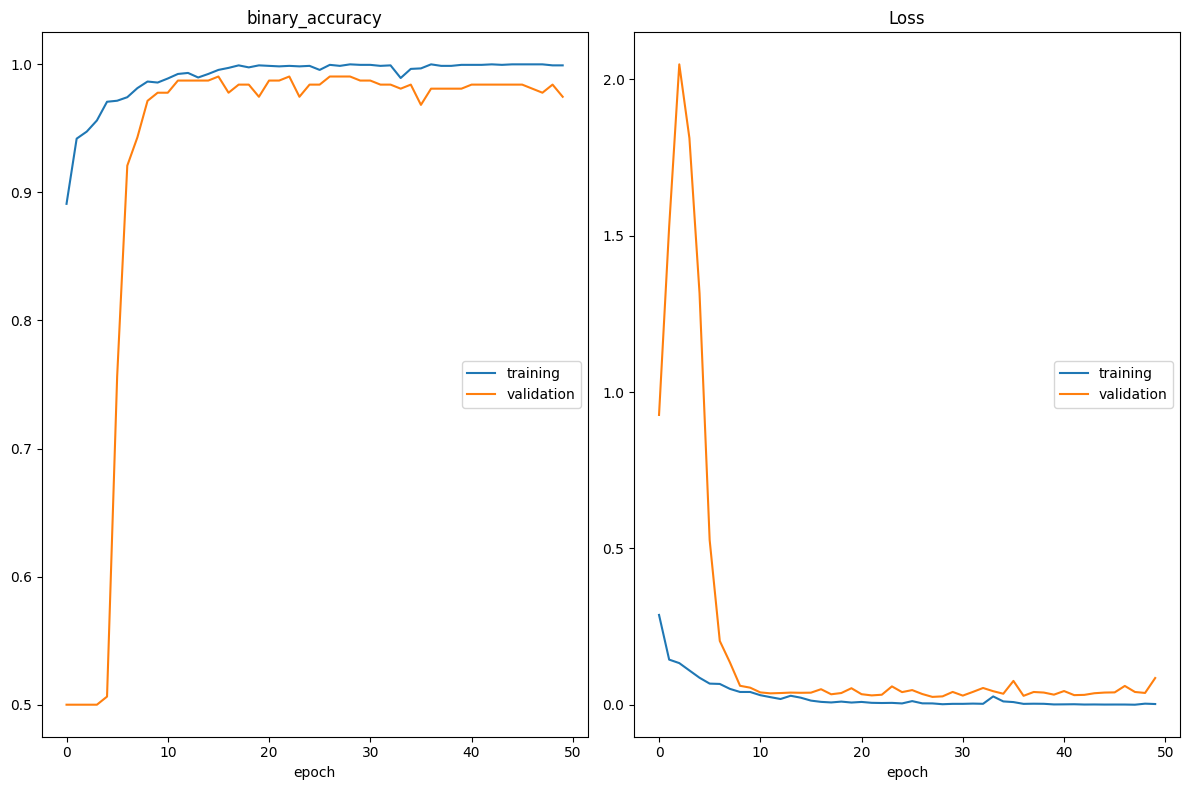

binary_accuracy
	training         	 (min:    0.891, max:    1.000, cur:    0.999)
	validation       	 (min:    0.500, max:    0.991, cur:    0.975)
Loss
	training         	 (min:    0.001, max:    0.288, cur:    0.003)
	validation       	 (min:    0.026, max:    2.048, cur:    0.086)
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - binary_accuracy: 0.9996 - loss: 0.0026 - val_binary_accuracy: 0.9747 - val_loss: 0.0860


In [21]:
start_time = time.time()
custom_hist = custom_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data= (x_val, y_val), callbacks=[PlotLossesKeras()])
custom_elapsed_time = time.time() - start_time

In [22]:
# Evaluate the model
custom_loss, custom_acc = custom_model.evaluate(x_test, y_test)

# Print the results
print(f"Test Loss: {custom_loss}")
print(f"Test Accuracy: {custom_acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - binary_accuracy: 0.9282 - loss: 0.2823
Test Loss: 0.2693839371204376
Test Accuracy: 0.9335442781448364


### Transfer Learning

The Transfer Learning approach utilized in this project leverages a pre-trained model to enhance the pneumonia detection task. 

- **Base Model**: A pre-trained ResNet152V2 on ImageNet, serves as the base model. This network has already learned to extract 
    meaningful features from a wide range of images.

- **Feature Extraction**: The pre-trained model's convolutional layers are used to extract high-level features from the X-ray images. These layers 
    capture general patterns and structures that are beneficial for the pneumonia classification task.

- **Custom Classification Head**: A new classification head is added on top of the pre-trained model. This head includes a global average pooling 
    layer followed by a dense layer with a sigmoid activation function. This custom head is specifically trained on the pneumonia dataset to adapt 
    the model to the new classification task.

The Transfer Learning approach allows for effective utilization of established feature extraction capabilities while tailoring the model to the 
specific needs of pneumonia detection, leveraging pre-existing knowledge for improved performance and efficiency.


In [23]:
def convNet():
    base_model = ResNet152V2(weights='imagenet', include_top = False, input_shape=(img_size, img_size, 3))
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    cnn = Sequential()
    cnn.add(Input(shape=(img_size, img_size,3)))
    cnn.add(base_model)
    cnn.add(GlobalAveragePooling2D())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.1))
    cnn.add(Dense(1, activation='sigmoid'))
    
    return cnn

# Training The CNN
tl_model = convNet()
tl_model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=['binary_accuracy'])
tl_model.summary()  

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

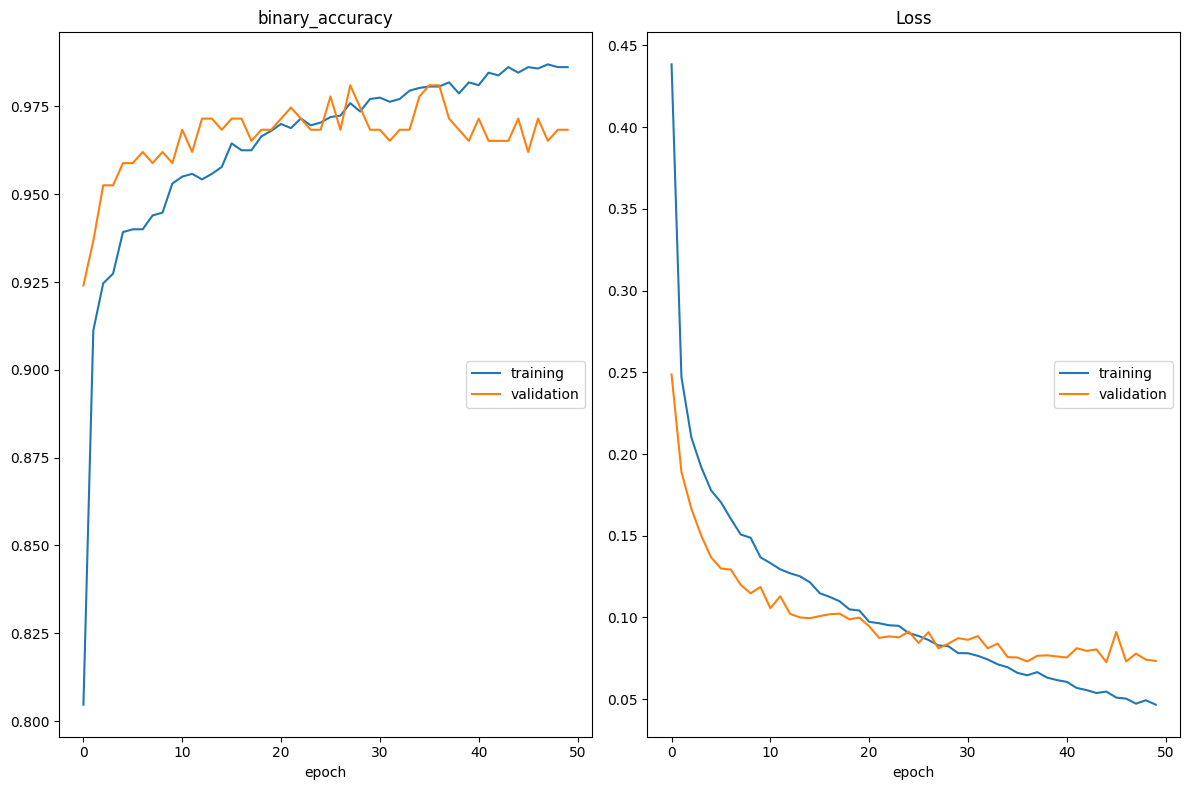

binary_accuracy
	training         	 (min:    0.805, max:    0.987, cur:    0.986)
	validation       	 (min:    0.924, max:    0.981, cur:    0.968)
Loss
	training         	 (min:    0.047, max:    0.438, cur:    0.047)
	validation       	 (min:    0.073, max:    0.249, cur:    0.073)
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - binary_accuracy: 0.9847 - loss: 0.0494 - val_binary_accuracy: 0.9684 - val_loss: 0.0734


In [24]:
start_time = time.time()
tl_hist = tl_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data= (x_val, y_val), callbacks=[PlotLossesKeras()])
tl_elapsed_time = time.time() - start_time

In [25]:
# Evaluate the model
tl_loss, tl_acc = tl_model.evaluate(x_test, y_test)

# Print the results
print(f"Test Loss: {tl_loss}")
print(f"Test Accuracy: {tl_acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - binary_accuracy: 0.9578 - loss: 0.0864
Test Loss: 0.07653311640024185
Test Accuracy: 0.9651898741722107


### Partial Fine-Tuning

The Partial Fine-Tuning approach focuses on adapting a pre-trained model to the pneumonia detection task by updating only a subset of its layers.

- **Base Model**: A pre-trained ResNet152V2 on ImageNet, is used as the foundation. This network has already 
developed robust feature extraction capabilities.

- **Frozen Layers**: The earlier layers of the pre-trained model, which capture general features, are kept frozen. This preserves the learned 
features from the initial training and avoids disrupting the foundational knowledge.

- **Fine-Tuned Layers**: The last ten layers of the model are unfrozen and trained on the pneumonia dataset. These layers are adapted to specialize 
in distinguishing between pneumonia and normal X-ray images.

- **Custom Classification Head**: A new classification head, consisting of a global average pooling layer followed by two dense layers The first 
dense layer has 128 neurons, and the second dense layer is the classifier with one neuron and a sigmoid activation function. This head is 
specifically trained to classify the X-ray images based on the fine-tuned features.

Partial fine-tuning enables the model to retain valuable general features while adapting to the specifics of the pneumonia detection task, 
    optimizing both the training process and model performance.


In [26]:
def convNet():
    base_model = ResNet152V2(weights='imagenet', include_top = False, input_shape=(img_size, img_size, 3))
    # Freeze all layers except for the
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    cnn = Sequential()
    cnn.add(Input(shape=(img_size, img_size,3)))
    cnn.add(base_model)
    cnn.add(GlobalAveragePooling2D())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.1))
    cnn.add(Dense(1, activation='sigmoid'))
    
    return cnn

# Training The CNN
pft_model = convNet()
pft_model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=['binary_accuracy'])
pft_model.summary()  

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 3,678,465 (14.03 MB)

 Non-trainable params: 54,915,584 (209.49 MB)

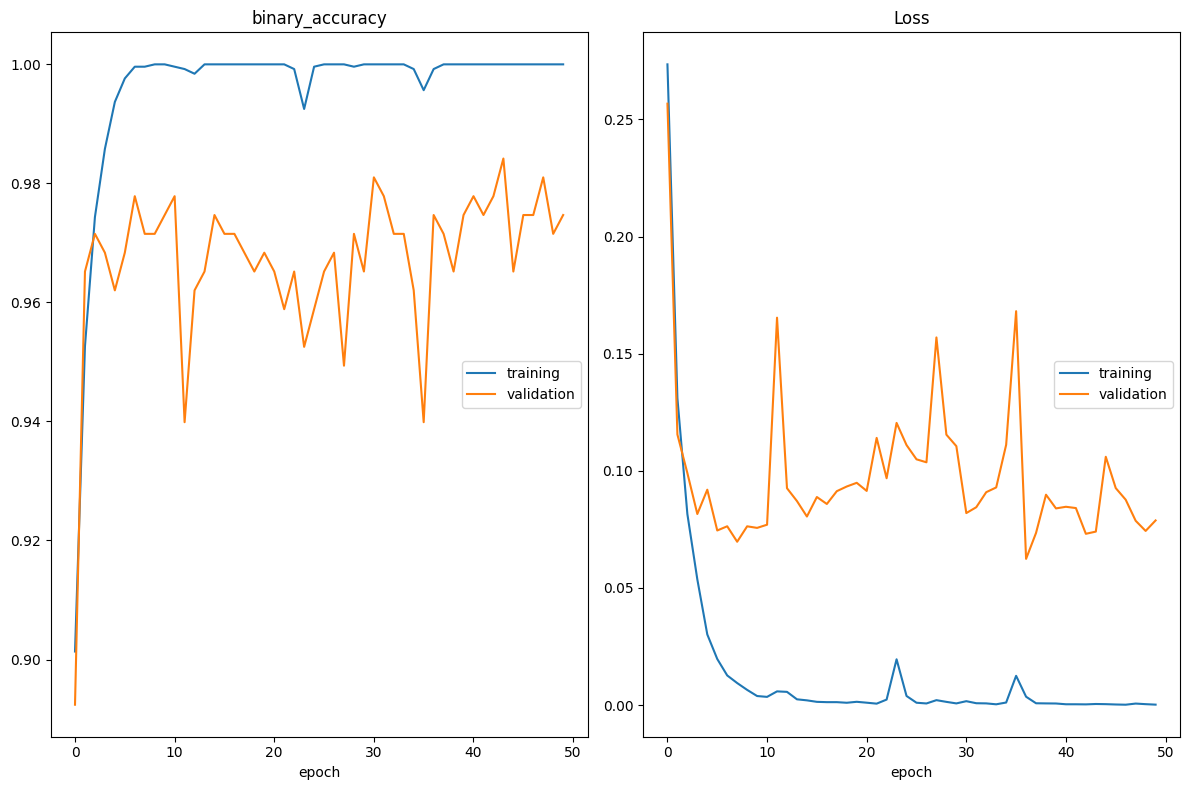

binary_accuracy
	training         	 (min:    0.901, max:    1.000, cur:    1.000)
	validation       	 (min:    0.892, max:    0.984, cur:    0.975)
Loss
	training         	 (min:    0.000, max:    0.274, cur:    0.000)
	validation       	 (min:    0.062, max:    0.257, cur:    0.079)
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 260ms/step - binary_accuracy: 1.0000 - loss: 3.8594e-04 - val_binary_accuracy: 0.9747 - val_loss: 0.0788


In [27]:
start_time = time.time()
pft_hist = pft_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data= (x_val, y_val), callbacks=[PlotLossesKeras()])
pft_elapsed_time = time.time() - start_time

In [28]:
# Evaluate the model
pft_loss, pft_acc = pft_model.evaluate(x_test, y_test)

# Print the results
print(f"Test Loss: {pft_loss}")
print(f"Test Accuracy: {pft_acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - binary_accuracy: 0.9679 - loss: 0.0960
Test Loss: 0.09933721274137497
Test Accuracy: 0.9683544039726257


### Full Fine-Tuning

The Full Fine-Tuning approach involves extensive adaptation of a pre-trained model to optimize performance for the pneumonia detection task.

- **Base Model**: A pre-trained ResNet152V2 on ImageNet, is employed as the starting point. This model has already learned to extract a wide range of features from various images.

- **Unfrozen Layers**: Unlike partial fine-tuning, all layers of the pre-trained model are unfrozen. This allows for the adjustment of every parameter in the network during the training process.

- **End-to-End Training**: The entire network, including both the pre-trained layers and the new classification head, is trained on the pneumonia dataset. This comprehensive training enables the model to fully adapt its feature extraction and classification capabilities to the specific characteristics of pneumonia X-ray images.

- **Custom Classification Head**: A new classification head, featuring a global average pooling layer followed by a dense layer with a softmax activation function, is integrated. This head is fine-tuned alongside the rest of the network to ensure accurate classification.

Full fine-tuning facilitates thorough adaptation of the model to the pneumonia detection task by allowing fine adjustments across all layers, potentially leading to enhanced performance and model accuracy.


In [29]:
def convNet():
    base_model = ResNet152V2(weights='imagenet', include_top = False, input_shape=(img_size, img_size, 3))
    # Freeze all layers except for the
    for layer in base_model.layers:
        layer.trainable = True

    cnn = Sequential()
    cnn.add(Input(shape=(img_size, img_size,3)))
    cnn.add(base_model)
    cnn.add(GlobalAveragePooling2D())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.1))
    cnn.add(Dense(1, activation='sigmoid'))
    
    return cnn

# Training The CNN
fft_model = convNet()
fft_model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
fft_model.summary()  

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,594,049 (223.52 MB)

 Trainable params: 58,450,305 (222.97 MB)

 Non-trainable params: 143,744 (561.50 KB)

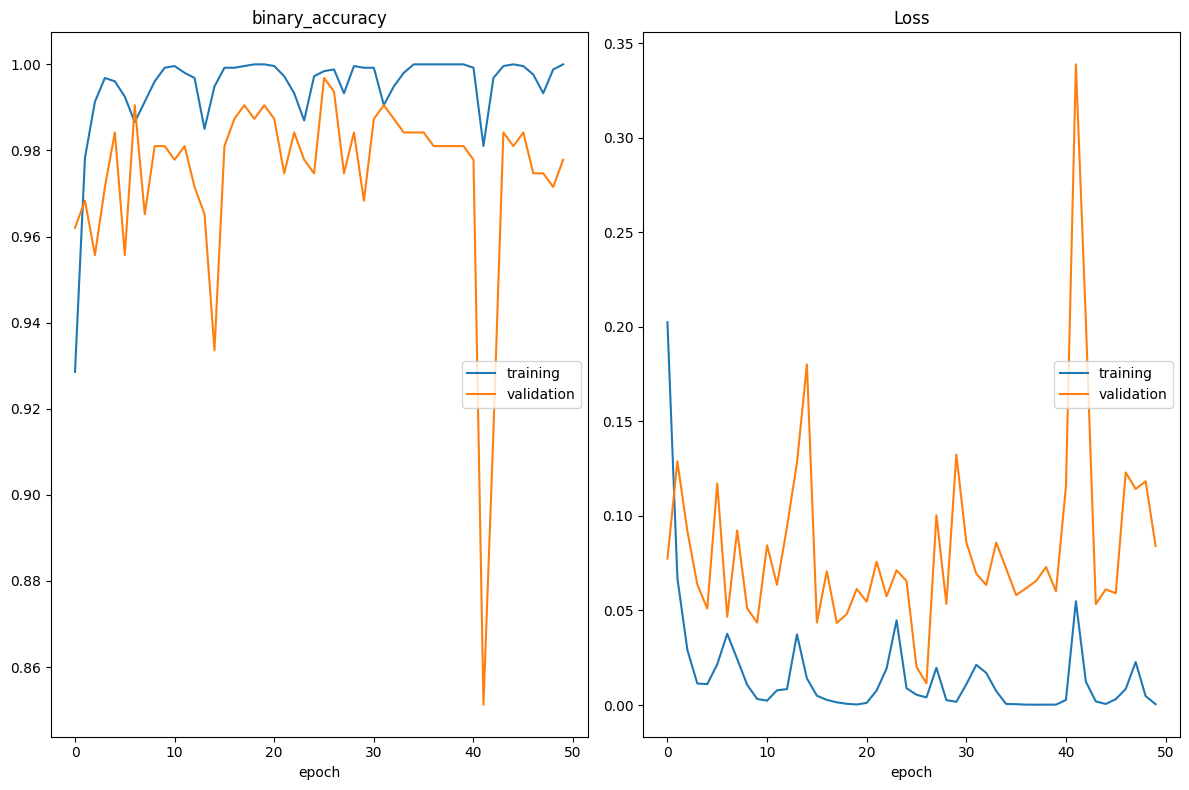

binary_accuracy
	training         	 (min:    0.929, max:    1.000, cur:    1.000)
	validation       	 (min:    0.851, max:    0.997, cur:    0.978)
Loss
	training         	 (min:    0.000, max:    0.202, cur:    0.000)
	validation       	 (min:    0.011, max:    0.339, cur:    0.084)
80/80 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - binary_accuracy: 1.0000 - loss: 4.4041e-04 - val_binary_accuracy: 0.9778 - val_loss: 0.0841


In [30]:
start_time = time.time()
fft_hist = fft_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data= (x_val, y_val), callbacks=[PlotLossesKeras()])
fft_elapsed_time = time.time() - start_time

In [31]:
# Evaluate the model
fft_loss, fft_acc = fft_model.evaluate(x_test, y_test)

# Print the results
print(f"Test Loss: {fft_loss}")
print(f"Test Accuracy: {fft_acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - binary_accuracy: 0.9754 - loss: 0.1281
Test Loss: 0.1320502907037735
Test Accuracy: 0.9715189933776855


## Results

The results section will begin with an examination of the learning curves for each implemented model, showcasing how training and validation accuracy and loss metrics evolve over epochs. Following this, a comprehensive analysis will be conducted to evaluate several key performance aspects such as accuracy and precision, analysis of the correct and false predictions, computational cost, divergence of the models, and statistical analysis.

### Learning Curves

The learning curves for each implemented model provide a visual representation of the training and validation performance over the course of training. These curves plot the accuracy and loss metrics as functions of the number of epochs, offering valuable insights into the models' learning dynamics.

- **Training Accuracy and Loss**: The training accuracy curve shows how the model's performance improves on the training dataset as learning progresses, while the training loss curve indicates how well the model is fitting the training data. A decreasing loss and increasing accuracy typically signify effective learning.

- **Validation Accuracy and Loss**: The validation accuracy curve reflects the model's performance on a separate validation dataset, which helps in assessing generalization ability. The validation loss curve provides insights into how well the model is performing on unseen data. A stable or improving validation accuracy and a decreasing validation loss suggest good generalization and prevent overfitting.

- **Convergence**: The learning curves will also reveal the convergence behavior of each model. Ideally, the training and validation curves should converge, indicating that the model is learning effectively without overfitting or underfitting.

By analyzing these curves, one can evaluate how quickly and effectively each model learns and generalizes, which is crucial for understanding their overall performance and suitability for the pneumonia detection task.


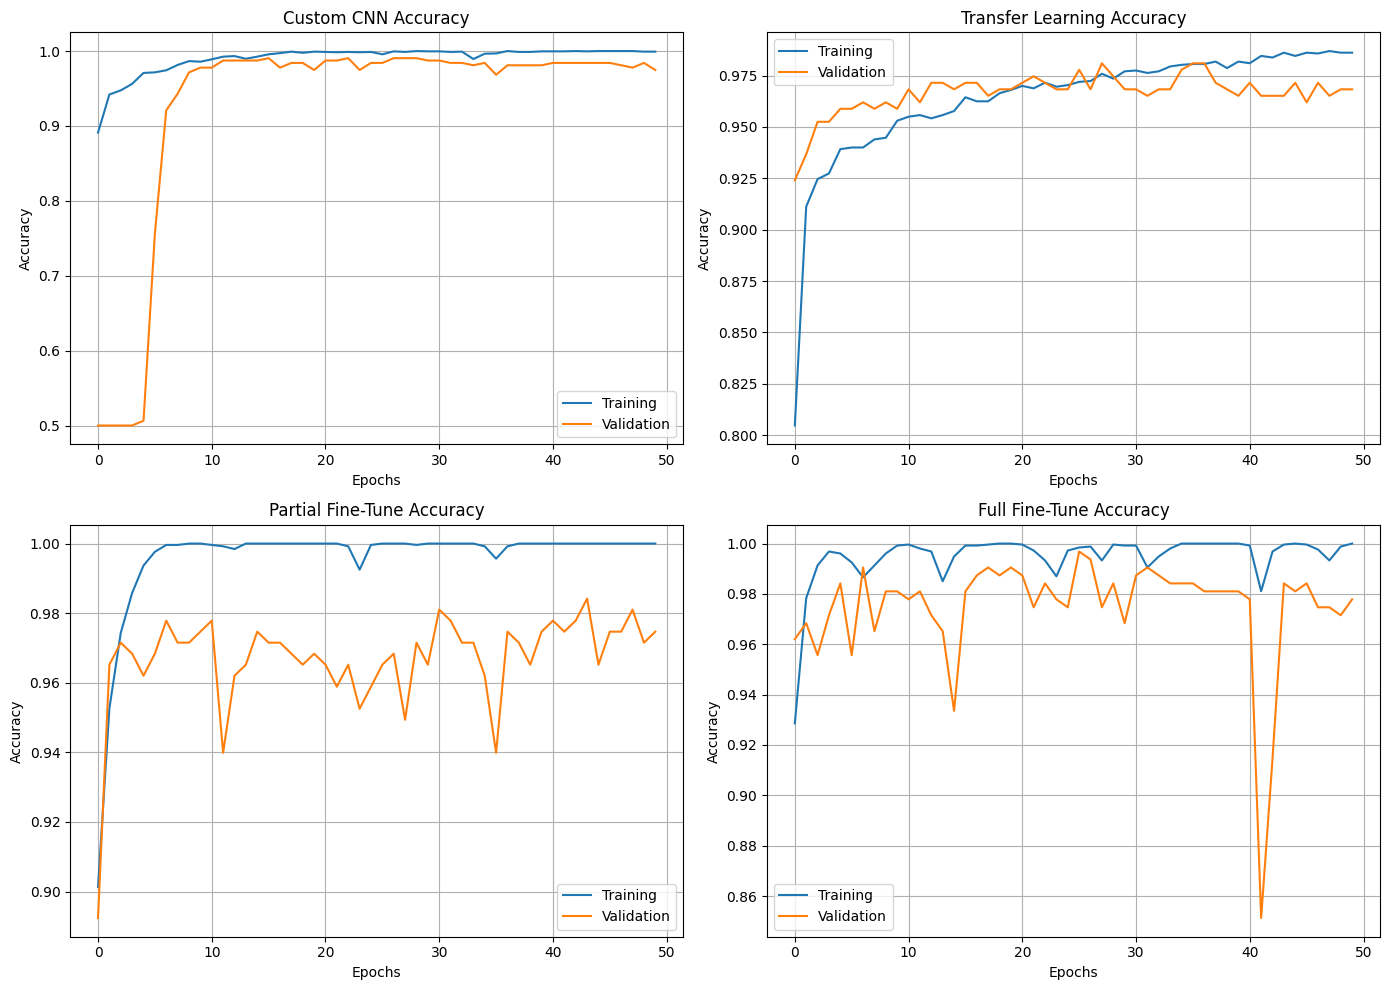

In [32]:
histories = [custom_hist, tl_hist, pft_hist, fft_hist]
titles = ['Custom CNN', 'Transfer Learning', 'Partial Fine-Tune', 'Full Fine-Tune']

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, history in enumerate(histories):
    axs[i].plot(history.history['binary_accuracy'], label='Training')
    axs[i].plot(history.history['val_binary_accuracy'], label='Validation')
    axs[i].set_title(titles[i] + ' Accuracy')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Accuracy')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

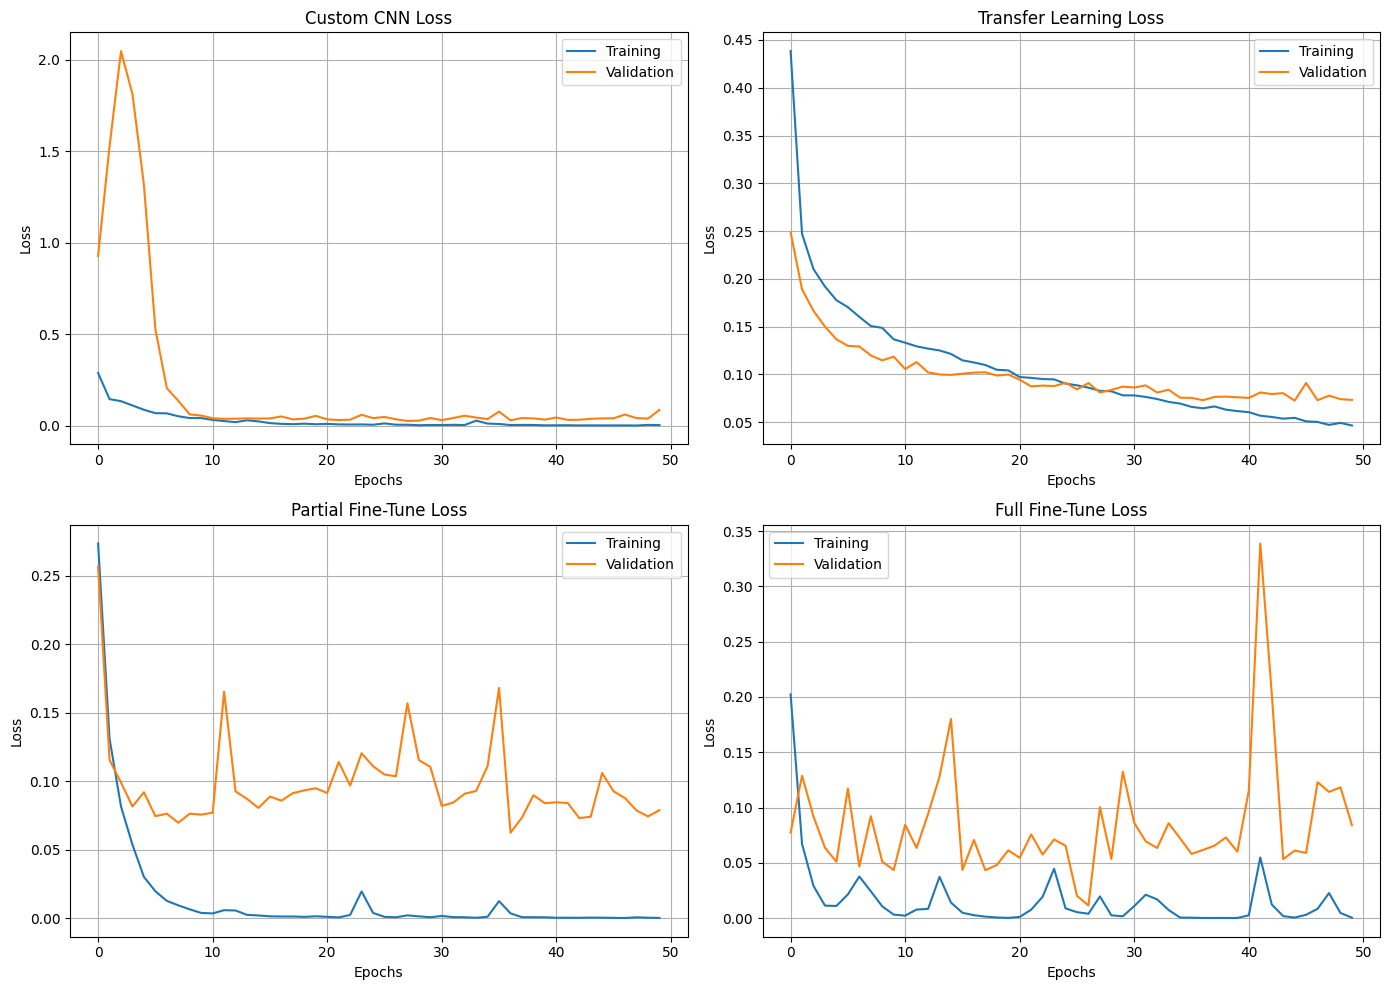

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, history in enumerate(histories):
    axs[i].plot(history.history['loss'], label='Training')
    axs[i].plot(history.history['val_loss'], label='Validation')
    axs[i].set_title(titles[i] + ' Loss')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

The analysis of the learning curves for each implemented model reveals a slight tendency towards overfitting. Specifically, while the training accuracy improves and the training loss decreases consistently, the validation accuracy and validation loss show minor deviations, indicating that the models are fitting the training data slightly better than the validation data.

Despite this tendency towards overfitting, the models demonstrate effective generalization when evaluated on the testing data. The testing results confirm that, although the models have slightly overfitted to the training data, they still perform well on unseen data. This suggests that the models are capable of generalizing the learned features to new X-ray images, maintaining strong performance in distinguishing between pneumonia and normal X-rays. Overall, while some overfitting is present, the models' ability to generalize effectively underscores their utility for practical pneumonia detection applications.


In [34]:
def refined_predictions(model, x):
    predictions = model.predict(x, verbose=1)
    return np.where(predictions > 0.5, 1, 0), predictions
    
custom_preds, custom_true_prds = refined_predictions(custom_model, x_test)
tl_preds, tl_true_prds = refined_predictions(tl_model, x_test)
pft_preds, pft_true_prds = refined_predictions(pft_model, x_test)
fft_preds, fft_true_prds = refined_predictions(fft_model, x_test)

2024-08-16 16:27:17.675388: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step 
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step

2024-08-16 16:28:48.479289: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


10/10 ━━━━━━━━━━━━━━━━━━━━ 71s 4s/step 
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step

2024-08-16 16:30:04.278258: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step 


In [35]:
def compute_scores(y_true, y_preds):
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='weighted')
    recall = recall_score(y_true, y_preds, average='weighted')
    f1 = f1_score(y_true, y_preds, average='weighted')

    return accuracy, precision, recall, f1
    

predictins = [custom_preds, tl_preds, pft_preds, fft_preds]
        
metrics = {}

for i in range(len(titles)):
    accuracy, precision, recall, f1 = compute_scores(y_test, predictins[i])
    
    metrics[titles[i]] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

### Evaluation Metrics

The performance of each model is evaluated using key metrics: accuracy, precision, recall, and F1-score. These metrics provide a comprehensive view of how well the models classify X-ray images as either pneumonia or normal.

- **Accuracy**: Accuracy measures the proportion of correctly classified images (both pneumonia and normal) out of the total number of images. It provides a general indication of overall model performance. Higher accuracy reflects a better ability to correctly classify X-ray images.

- **Precision**: Precision is the ratio of true positive predictions to the total number of positive predictions made by the model. It evaluates how many of the predicted positive cases (pneumonia) are actually correct. Higher precision indicates fewer false positives and a greater reliability in detecting pneumonia when it is predicted.

- **Recall**: Recall, or sensitivity, measures the ratio of true positive predictions to the total number of actual positive cases. It assesses how effectively the model identifies all actual positive cases (pneumonia). Higher recall indicates that the model is effective at capturing most of the pneumonia cases.

- **F1-Score**: The F1-score is the harmonic mean of precision and recall, providing a single metric that balances both aspects. It is particularly useful when dealing with imbalanced datasets, where one class (e.g., pneumonia) might be less frequent than the other. A higher F1-score indicates a good balance between precision and recall, reflecting overall model performance in detecting pneumonia.

By analyzing these metrics, a detailed understanding of each model's strengths and weaknesses can be achieved, guiding further refinements and improvements in the pneumonia detection system.


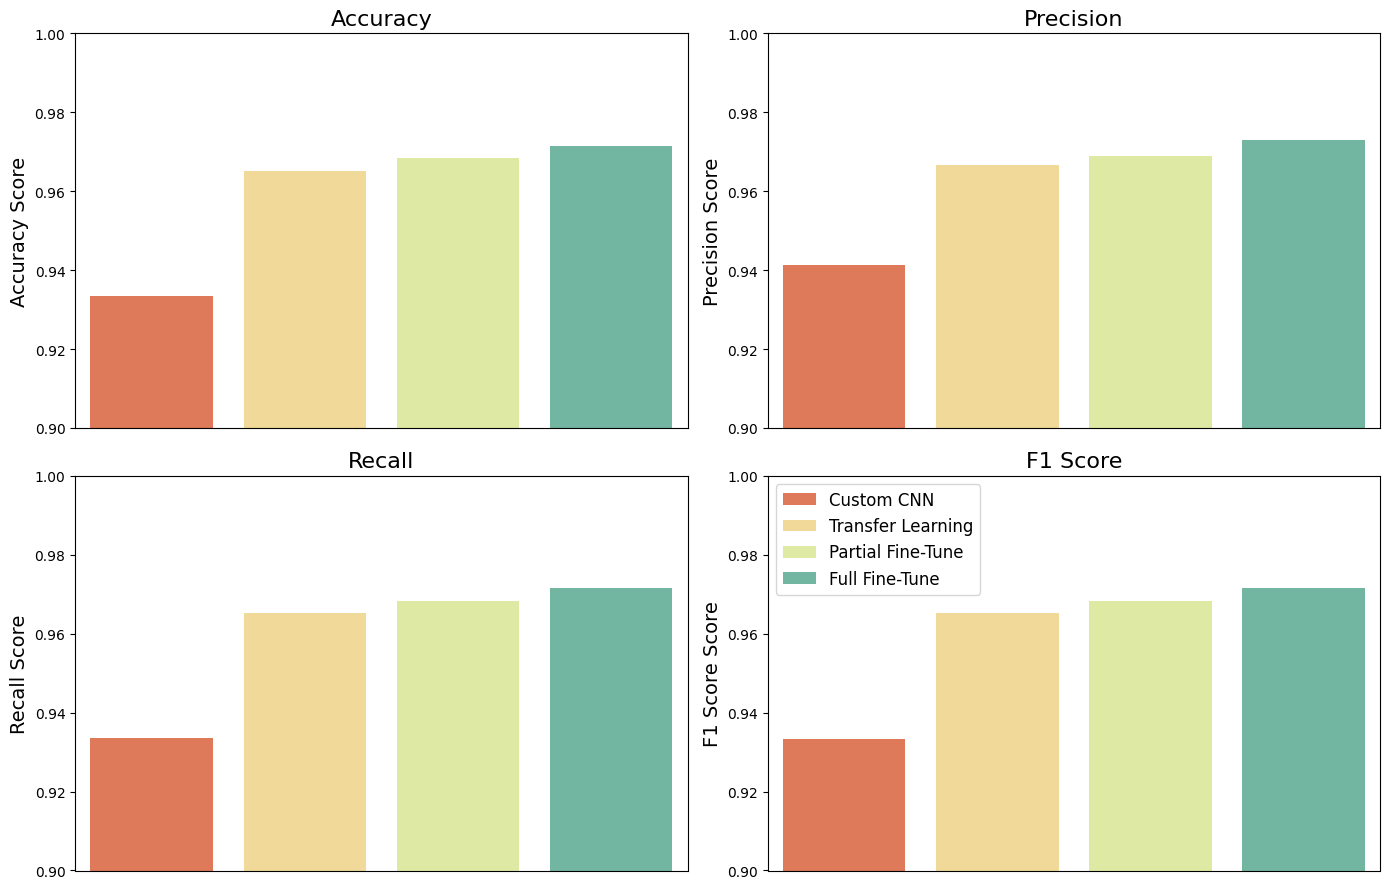

In [36]:
# Convert metrics dictionary to a format suitable for plotting
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
model_names = list(metrics.keys())
data = {metric: [metrics[model][metric] for model in model_names] for metric in metric_names}

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 9))
axs = axs.flatten()

for i, metric in enumerate(metric_names):
    sns.barplot(x=model_names, y=data[metric], ax=axs[i], palette='Spectral')
    axs[i].set_title(f'{metric}', fontsize=16)
    axs[i].set_ylim(0.9, 1)  # Assuming all metrics range from 0 to 1
    axs[i].set_ylabel(f'{metric} Score', fontsize=14)
    #axs[i].set_xlabel('Model', fontsize=14)
    axs[i].tick_params(axis='x', labelbottom=False)  # Remove model names from x-axis
    axs[i].set_xticks([])

# Add legend in the last subplot
handles, labels = axs[0].get_legend_handles_labels()
axs[-1].legend(handles=axs[0].patches, labels=model_names, loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

The evaluation of accuracy, precision, recall, and F1-score reveals that Full Fine-Tuning models consistently outperform the others, reflecting their superior performance in pneumonia detection. Accuracy, which measures the proportion of correct predictions, was highest for Full Fine-Tuning models, indicating that these models correctly identified both pneumonia and normal X-ray images more frequently than the others. Precision, the ratio of true positives to predicted positives, was also highest for Full Fine-Tuning, demonstrating that this model made fewer false positive predictions. This suggests a high reliability in detecting pneumonia when it is predicted. 

Recall, the ratio of true positives to actual positives, was similarly highest for Full Fine-Tuning models. This indicates that this model successfully identified the majority of actual pneumonia cases, minimizing missed diagnoses. The F1-score, which balances precision and recall, was highest for Full Fine-Tuning models as well, reflecting an optimal trade-off between precision and recall and confirming their overall effectiveness.

In contrast, model employing Transfer Learning achieved the second-highest scores across all metrics. While these models benefited from pre-trained features, their performance was slightly lower than Full Fine-Tuning due to the inability to adjust all network layers. Partial Fine-Tuning models, which only fine-tune certain layers while keeping others frozen, showed reduced scores, particularly in recall, indicating that they did not capture all the necessary features for accurate pneumonia detection. Finally, the Custom CNN, trained from scratch, had the lowest scores in all metrics, highlighting the limitations of learning features from scratch without the advantage of pre-trained weights. 

Overall, these results underscore the importance of extensive adaptation and fine-tuning in achieving high performance for pneumonia detection, with Full Fine-Tuning models demonstrating the best balance and effectiveness across all evaluated metrics. To further understand the scores, a deeper look into the confusion matrix is provided.


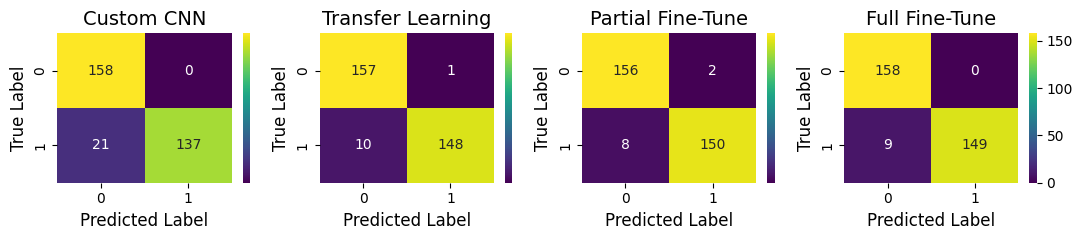

In [37]:
fig, axs = plt.subplots(1, 4, figsize=(11, 2.5))
axs = axs.flatten()

for i, preds in enumerate(predictins):
    cm = confusion_matrix(y_test, preds)
    sns_heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', ax=axs[i])
    if i != 3:
        sns_heatmap.collections[0].colorbar.ax.yaxis.set_ticks([])
    axs[i].set_title(titles[i], fontsize=14)
    axs[i].set_xlabel("Predicted Label", fontsize=12)
    axs[i].set_ylabel("True Label", fontsize=12)

plt.tight_layout()
plt.show()

The Full Fine-Tuning model demonstrates the best performance in detecting pneumonia, achieving the highest true positives and lowest false negatives, though at the cost of a higher false positive rate. Transfer Learning and Partial Fine-Tuning models also perform well, with similar true positive rates but varying in their identification of normal X-rays. The Custom CNN, while effective, has the lowest true negative rate and a higher false negative rate, indicating it could benefit from improved feature extraction and generalization. Overall, while Full Fine-Tuning provides the most accurate detection of pneumonia, a balance between detecting pneumonia and accurately identifying normal X-rays is crucial for practical applications.


### Training Time and Memory Consumption

In this project, to ensure a fair comparison of training time across models, the `loss function`, `optimizer`, `batch size`, and `learning rate` are kept consistent. This standardization allows for an accurate assessment of how the number of trainable parameters affects training time. The training time is influenced by the model's complexity, with a higher number of trainable parameters generally resulting in longer training durations due to the increased computations required. Similarly, memory consumption is directly related to the number of trainable parameters, with models having more parameters requiring more memory for storage and updates. By maintaining these training settings constant, the comparison focuses on the inherent differences in training time and memory usage due to the varying model architectures.


In [38]:
# Calculate the number of trainable parameters
# This approach is not precise
def trainable_parameters(model):
    non_trainable_params = np.sum([np.prod(var.shape) for var in model.non_trainable_variables])
    return model.count_params() - non_trainable_params

custom_params = trainable_parameters(custom_model)
tl_params = trainable_parameters(tl_model)
pft_params = trainable_parameters(pft_model)
fft_params = trainable_parameters(fft_model)

In [39]:
print("Number of trainable parameters for Custom CNN:          ", custom_params)
print("Number of trainable parameters for Transfer Learning:   ", tl_params)
print("Number of trainable parameters for Partial Fine-Tuning: ", pft_params)
print("Number of trainable parameters for Full Fine-Tuning:    ", fft_params)

Number of trainable parameters for Custom CNN:           2032313
Number of trainable parameters for Transfer Learning:    262399
Number of trainable parameters for Partial Fine-Tuning:  3678463
Number of trainable parameters for Full Fine-Tuning:     58450303


In [40]:
print(f"Total training time for Custom CNN:           {int(custom_elapsed_time/60)} minutes and {int(custom_elapsed_time%60)} seconds")
print(f"Total training time for Transfer Learning:    {int(tl_elapsed_time/60)} minutes and {int(tl_elapsed_time%60)} seconds")
print(f"Total training time for Partial Fine-Tuning:  {int(pft_elapsed_time/60)} minutes and {int(pft_elapsed_time%60)} seconds")
print(f"Total training time for Full Fine-Tuning:     {int(fft_elapsed_time/60)} minutes and {int(fft_elapsed_time%60)} seconds")

Total training time for Custom CNN:           5 minutes and 49 seconds
Total training time for Transfer Learning:    16 minutes and 11 seconds
Total training time for Partial Fine-Tuning:  17 minutes and 43 seconds
Total training time for Full Fine-Tuning:     109 minutes and 14 seconds


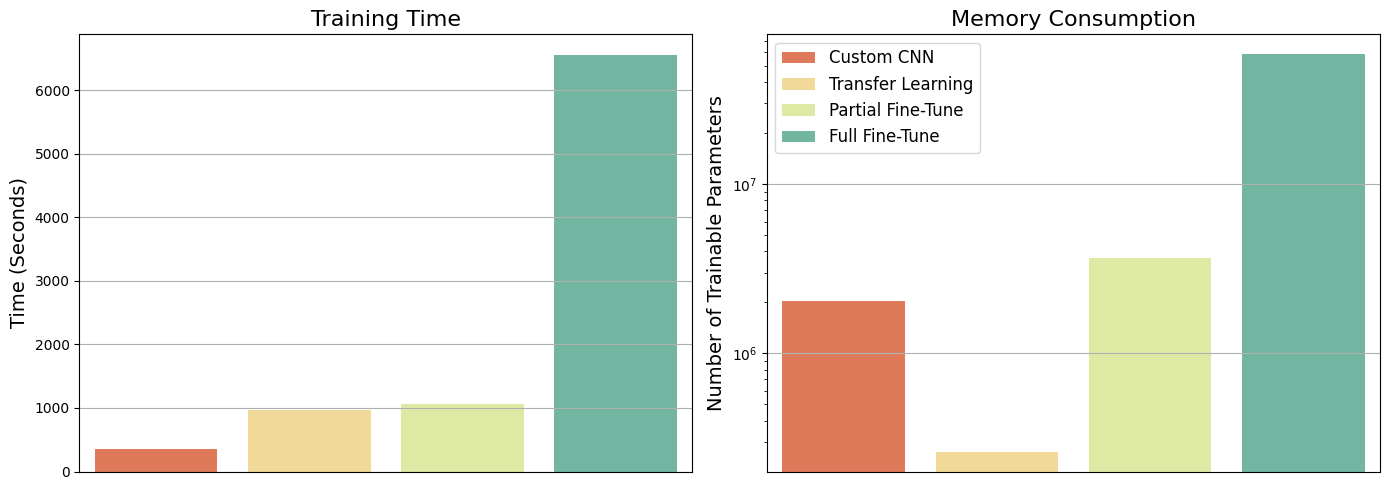

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs = axs.flatten()

sns.barplot(x=model_names,
            y=[custom_elapsed_time, tl_elapsed_time, pft_elapsed_time, fft_elapsed_time],
            ax=axs[0], palette='Spectral')
axs[0].set_title("Training Time", fontsize=16)
axs[0].set_ylabel('Time (Seconds)', fontsize=14)
axs[0].tick_params(axis='x', labelbottom=False)  # Remove model names from x-axis
axs[0].set_xticks([])
axs[0].grid()

sns.barplot(x=model_names,
            y=[custom_params, tl_params, pft_params, fft_params],
                ax=axs[1], palette='Spectral')
axs[1].set_title("Memory Consumption", fontsize=16)
axs[1].set_ylabel('Number of Trainable Parameters', fontsize=14)
axs[1].tick_params(axis='x', labelbottom=False)  # Remove model names from x-axis
axs[1].set_xticks([])
axs[1].grid()
plt.yscale('log')

# Add legend in the last subplot
handles, labels = axs[0].get_legend_handles_labels()
axs[-1].legend(handles=axs[0].patches, labels=model_names, loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

The training times and the number of trainable parameters across the models reveal the impact of model complexity on computational demands. The Custom CNN, which has fewer trainable parameters, completes training in the shortest time. This shorter duration is attributed to the lower computational burden associated with fewer parameters. In contrast, the Transfer Learning model, despite having fewer parameters than the Custom CNN, requires a longer training time due to the additional layers involved in fine-tuning. The Partial Fine-Tuning model, with a higher number of trainable parameters, shows a longer training time, reflecting the increased computational requirements. The Full Fine-Tuning model, with the largest number of parameters, demands the most extended training time. This extended duration is a result of the comprehensive adjustment of a large number of parameters, requiring significant computational resources. Overall, the data illustrate that more complex models, with higher numbers of trainable parameters, necessitate more time and computational resources for training, impacting both training duration and memory usage.


### Evaluation Metrics

To assess the statistical significance of the differences in performance between the four models, pairwise comparisons were conducted using a t-test. The p-values indicate whether the observed differences between the models' performances are statistically significant. A common threshold for significance is `p < 0.05`, meaning there is less than a 5% chance that the observed difference is due to random variation.

In [42]:
custom_prds = [i.item() for i in custom_true_prds]
tl_prds = [i.item() for i in tl_true_prds]
pft_prds = [i.item() for i in pft_true_prds]
fft_prds = [i.item() for i in fft_true_prds]

prds = [custom_prds, tl_prds, pft_prds, fft_prds]

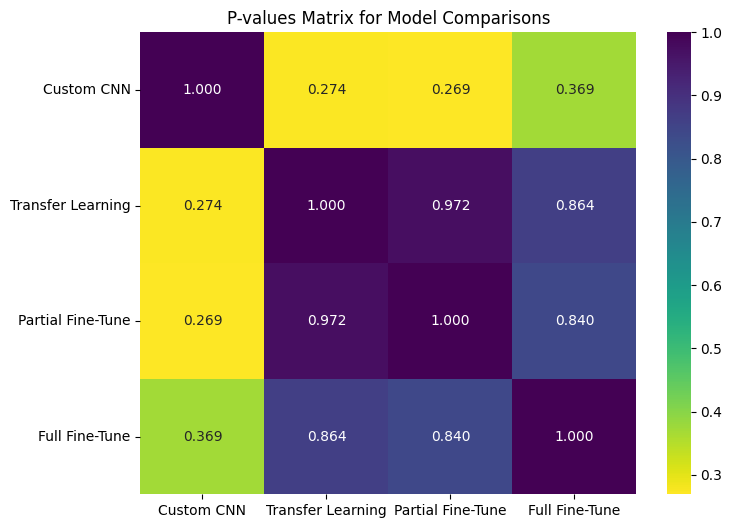

In [58]:
import scipy.stats as stats


# Initialize a 4x4 matrix to store p-values
p_values_matrix = np.zeros((len(prds), len(prds)))

# Compute p-values for each pair of models
for i in range(len(prds)):
    for j in range(len(prds)):
        if i != j:
            _, p_value = stats.ttest_ind(prds[i], prds[j])
            p_values_matrix[i, j] = p_value
        else:
            p_values_matrix[i, j] = True  # Set diagonal to NaN for clarity

# Create a heatmap for the p-values matrix
plt.figure(figsize=(8, 6))
sns.heatmap(p_values_matrix, annot=True, fmt='.3f', cmap='viridis_r', xticklabels=model_names, yticklabels=model_names)
plt.title('P-values Matrix for Model Comparisons')
plt.show()

The statistical analysis conducted on the performance scores of the four models reveals that there is no significant difference between them. This conclusion is drawn from the pairwise t-tests performed, where the p-values indicate whether the observed differences in performance are statistically significant.

Despite variations in the raw performance metrics, the computed p-values across model comparisons were all above the common threshold of 
p<0.05
p<0.05. This suggests that any observed differences are likely due to random variation rather than inherent disparities in model performance.

The analysis implies that the models can be considered statistically equivalent in terms of their performance on the given task. As a result, the selection between these models may depend more on other factors, such as computational efficiency, interpretability, or ease of deployment. This lack of significant difference underscores the robustness of each model and suggests that any of them could be a viable choice depending on the specific needs of the application.

The statistical analysis conducted on the performance scores of the four models reveals that there is no significant difference between them. This result is drawn from the pairwise t-tests performed, where the p-values indicate whether the observed differences in performance are statistically significant.

Despite variations in the raw performance metrics, the computed p-values across model comparisons were all above the common threshold of 
`p < 0.05`. This suggests that any observed differences are likely due to random variation rather than inherent disparities in model performance.

### Conclusion

In this project, the performance of several models was evaluated, with a focus on prediction accuracy and precision. The results demonstrate that the full fine-tuning approach achieves the highest prediction accuracy and precision among all the models. However, it is also the slowest in terms of training time and requires the most memory consumption, making it less practical for applications with limited computational resources.

On the other hand, the Custom CNN model, while very light in parameters and the fastest to train, achieved the lowest accuracy and precision scores. Despite its efficiency, the trade-off in performance may not justify its use in scenarios where accuracy is critical.

Overall, statistical analysis reveals no significant difference between the models, indicating that the variations in performance are not substantial enough to favor one model over the others definitively. As a result, the choice between these models depends on individual preferences and specific use-case requirements, such as the importance of training speed, memory usage, or achieving the highest possible accuracy.
